# Imports



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms.transforms import Normalize
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from tqdm import notebook
from collections import Counter
import os
import time

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

# GPU checks

In [ ]:
print(f"\nDo you have access to cuda: {torch.cuda.is_available()} \n Which CUDA device code: {torch.cuda.current_device()} \n Name of CUDA DEVICE: {torch.cuda.get_device_name(0)}")


Do you have access to cuda: True 
 Which CUDA device code: 0 
 Name of CUDA DEVICE: Tesla V100-SXM2-16GB


In [ ]:
from torch._C import device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"GPU device: {device}")

GPU device: cuda


# Data loading

In [ ]:
data_dir = '../Data'

In [ ]:
transforms= transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
'''
Function to load data sets into dictionary
  - params: data directory
  - image_datasets: ['train'] or ['test']
  - Transformsations: ToTensor and Normalize
'''

image_datasets = {'train': datasets.CIFAR10(root=data_dir, train=True, download=True,
                            transform=transforms),
                  'test': datasets.CIFAR10(root=data_dir, train=False, download=True,
                            transform=transforms)
                  }




  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../Data/cifar-10-python.tar.gz to ../Data
Files already downloaded and verified


In [ ]:
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

In [ ]:
def get_val(image_datasets, TRAIN_SPLIT, VAL_SPLIT):

  numTrainSamples = int(len(image_datasets['train']) * TRAIN_SPLIT)
  numValSamples = int(len(image_datasets['train']) * VAL_SPLIT)
  (image_datasets['train'], val_data) = random_split(image_datasets['train'],
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))

  return val_data

In [ ]:
val_data = get_val(image_datasets, TRAIN_SPLIT, VAL_SPLIT)

In [ ]:
def data_loader(image_datasets, val_data, BATCH_SIZE=10):
  data_loaders = {
    'train': DataLoader(image_datasets['train'], BATCH_SIZE, shuffle=True),
    'val': DataLoader(val_data, BATCH_SIZE),
    'test': DataLoader(image_datasets['test'], BATCH_SIZE)}

  return data_loaders


In [ ]:
data_loaders = data_loader(image_datasets, val_data)

In [ ]:
for i, (im, lb) in enumerate(image_datasets['test']):
  break

In [ ]:
image_datasets

{'test': Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ../Data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ), 'train': <torch.utils.data.dataset.Subset at 0x7fd432e71a50>}

In [ ]:
# calculate steps per epoch for training and validation set
#trainSteps = len(data_loaders['train'].dataset) // BATCH_SIZE
#valSteps = len(data_loaders['val'].dataset) // BATCH_SIZE

In [ ]:
train_hist = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

# Optuna Optimisation

In [ ]:
def objective(trial):
  model = cnn_net(trial).to(device)

  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)


## Data Exploration

Images per class in both train and test data are balanced
* Each class in train has 5000 image
* Each class in test has 1000 image

In [ ]:
# Images per class
def img_per_class(str: 'x'):

  class_dict = image_datasets[x].class_to_idx
  y_label = image_datasets[x].targets
  img_per_class = Counter(y_label)

  return({k: img_per_class[v] for k, v in class_dict.items()})

In [ ]:
for x in ['train', 'test']:
  print(img_per_class(x))

{'airplane': 5000, 'automobile': 5000, 'bird': 5000, 'cat': 5000, 'deer': 5000, 'dog': 5000, 'frog': 5000, 'horse': 5000, 'ship': 5000, 'truck': 5000}
{'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}


Visualising images

In [ ]:
classes_dict = image_datasets['train'].class_to_idx
print(classes_dict)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [ ]:
for img, labels in data_loaders['train']:
  break

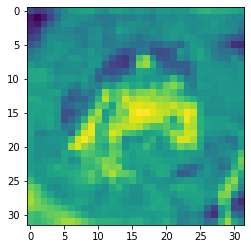

In [ ]:
plt.imshow(img[0][0])

In [ ]:
img.shape, labels.shape

(torch.Size([10, 3, 32, 32]), torch.Size([10]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird', 'horse', 'ship', 'cat']


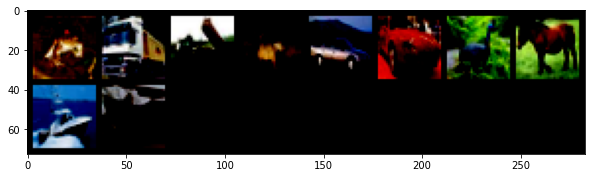

In [ ]:
#Visualising first batch of 16 train
reversed_dict = {value: key for key, value in classes_dict.items()}
new_list = [reversed_dict[x] for x in labels.tolist()]
print(new_list)

im = make_grid(img, nrow=8, padding =3, normalize=([ 0., 0., 0. ],[ 1/0.229, 1/0.224, 1/0.225 ]))
plt.figure(figsize=(10, 8))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))


# Convolutional Neural Network

In [ ]:
class ConvNet(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3, stride=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fcl = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1152, 100)
    )

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.fcl(out)

    return out

In [ ]:

#Creating instance of ConvNet and loading to Tesla GPU
cnn_net = ConvNet().to(device)
cnn_net

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fcl): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=100, bias=True)
  )
)

# Training Function

In [ ]:
if self.mixup == True:
      label = torch.zeros(182)
      label[target] = 1.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def train_model(model, optimizer, data_loader,  num_epochs, criterion=criterion):

  train_correct = []
  train_losses = []

  val_correct = []
  val_losses = []

  for epoch in total_epochs:
    model.train()

    trn_crrct = 0
    vl_crrct= 0

    for i, (x_train, y_train) in enumerate(data_loader['train']):

      x_train = x_train.to(device)
      y_train = y_train.to(device)


      y_pred = model(x_train)
      loss = criterion(y_pred, y_train)

      _, predicted = y_pred.max(1)
      batch_corrct = (predicted == y_train).sum()
      trn_crrct += batch_corrct

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (i + 1) % 10 == 0:
        total_epochs.set_description(
          'Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
            epoch + 1, num_epochs, i + 1, len(data_loader['train']), loss.item()))

    train_losses.append(loss)
    train_correct.append(trn_crrct)

    with torch.no_grad():
      for i, (x_val, y_val) in enumerate(data_loader['val']):

        x_val = x_val.to(device)
        y_val = y_val.to(device)

        val_pred = model(x_val)

        _, predicted = val_pred.max(1)
        vl_crrct += (predicted == y_val).sum()

    loss = criterion(val_pred, y_val)
    val_losses.append(loss)
    val_correct.append(vl_crrct)









In [ ]:
optimizer = torch.optim.Adam(cnn_net.parameters(), lr=3e-4)

In [ ]:
train_md = train_model(cnn_net, optimizer, data_loaders, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.646 | Accuracy: 77.394
Total Correct:  7.7394
Train Loss: 0.646 | Accuracy: 77.360
Total Correct:  7.736
Train Loss: 0.643 | Accuracy: 77.542
Total Correct:  7.7542
Train Loss: 0.641 | Accuracy: 77.548
Total Correct:  7.7548
Train Loss: 0.640 | Accuracy: 77.584
Total Correct:  7.7584
Train Loss: 0.636 | Accuracy: 77.730
Total Correct:  7.773
Train Loss: 0.635 | Accuracy: 77.690
Total Correct:  7.769
Train Loss: 0.635 | Accuracy: 77.782
Total Correct:  7.7782
Train Loss: 0.630 | Accuracy: 78.068
Total Correct:  7.8068
Train Loss: 0.634 | Accuracy: 77.878
Total Correct:  7.7878


In [ ]:
train_md = train_model(cnn_net, optimizer, data_loaders, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

NameError: ignored

# Validation


In [ ]:
from torch.autograd.grad_mode import no_grad
def validate_model(model, optimizer, val_loader, num_epochs, criterion=criterion):


  total_epochs = notebook.tqdm(range(num_epochs))


  for epoch in total_epochs:
    with torch.no_grad():
      model.eval()

      correct = 0.0
      running_loss=0.0
      total=0.0

      for i, (img, label) in enumerate(val_loader):
        img = img.to(device)
        label = label.to(device)

        outputs = model(img)


        loss = criterion(outputs, label)

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()

      train_loss=running_loss/len(val_loader)
      accu=100.*correct/total

    print('Validation Loss: %.3f | Validation Accuracy: %.3f'%(train_loss, accu))


In [ ]:
val_results = train_model(cnn_net, optimizer, data_loaders['val'], 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.493 | Accuracy: 84.232
Train Loss: 0.479 | Accuracy: 84.896
Train Loss: 0.465 | Accuracy: 85.504
Train Loss: 0.452 | Accuracy: 85.912
Train Loss: 0.439 | Accuracy: 86.464
Train Loss: 0.426 | Accuracy: 86.880
Train Loss: 0.414 | Accuracy: 87.456
Train Loss: 0.402 | Accuracy: 87.872
Train Loss: 0.391 | Accuracy: 88.200
Train Loss: 0.381 | Accuracy: 88.776


# Evaluation Function

In [ ]:
def eval_model(model, optimizer, test_loader, num_epochs, criterion=criterion):

  total_epochs = notebook.tqdm(range(num_epochs))

  for epoch in total_epochs:
    with torch.no_grad():
      model.eval()

      correct = 0.0
      running_loss=0.0
      total=0.0

      for i, (img, label) in enumerate(test_loader):
      #uploading images and labels to GPU
        img = img.to(device)
        label = label.to(device)

      #training model
        outputs = model(img)

      #computing losss
        loss = criterion(outputs, label)

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()

      train_loss=running_loss/len(test_loader)
      accu=100.*correct/total

    print('Evaluation Loss: %.3f | Evaluation Accuracy: %.3f'%(train_loss, accu))


In [ ]:
eval_results = eval_model(cnn_net, optimizer, data_loaders['test'], 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluation Loss: 1.058 | Evaluation Accuracy: 68.190
Evaluation Loss: 1.058 | Evaluation Accuracy: 68.190
Evaluation Loss: 1.058 | Evaluation Accuracy: 68.190
Evaluation Loss: 1.058 | Evaluation Accuracy: 68.190
Evaluation Loss: 1.058 | Evaluation Accuracy: 68.190
Evaluation Loss: 1.058 | Evaluation Accuracy: 68.190
Evaluation Loss: 1.058 | Evaluation Accuracy: 68.190
Evaluation Loss: 1.058 | Evaluation Accuracy: 68.190
Evaluation Loss: 1.058 | Evaluation Accuracy: 68.190
Evaluation Loss: 1.058 | Evaluation Accuracy: 68.190


In [ ]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

## Practise

In [ ]:
x_train = image_datasets['train'].data
y_train = image_datasets['train'].targets

x_test = image_datasets['test'].data
y_test = image_datasets['test'].targets


In [ ]:
      if (i + 1) % 10 == 0:
        total_epochs.set_description(
          'Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {}'.format(
              epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))

In [ ]:
 # print(metrics.classification_report(labels, predicted, digits=10))

  print('Accuracy of the network on the 10000 test images: {} %,'.format(100 * correct / total))
  print('ytrue: {}, ypred: {}'.format(labels.data, predicted))
#  print('The f1 score of the network on the test images: {}'.format(f1_batch))


In [ ]:


  correct = 0.0
  test_running_loss=0.0
  total = 0.0

  for i, (imgs, labels) in enumerate(val_loader):
    imgs = imgs.to(device)
    labels = labels.to(device)

    outputs = model(imgs)
    loss = criterion(outputs, labels)

    val_running_loss =

In [ ]:

      train_running_loss += loss.item()

      _, predicted = outputs.max(1)
      train_total += label.size(0)
      train_correct += predicted.eq(label).sum().item()

    train_loss=train_running_loss/len(data_loader['train'])
    train_accu=100.*correct/total

    print('Train Loss: %.3f | Train Accuracy: %.3f'%(train_loss,train_accu))